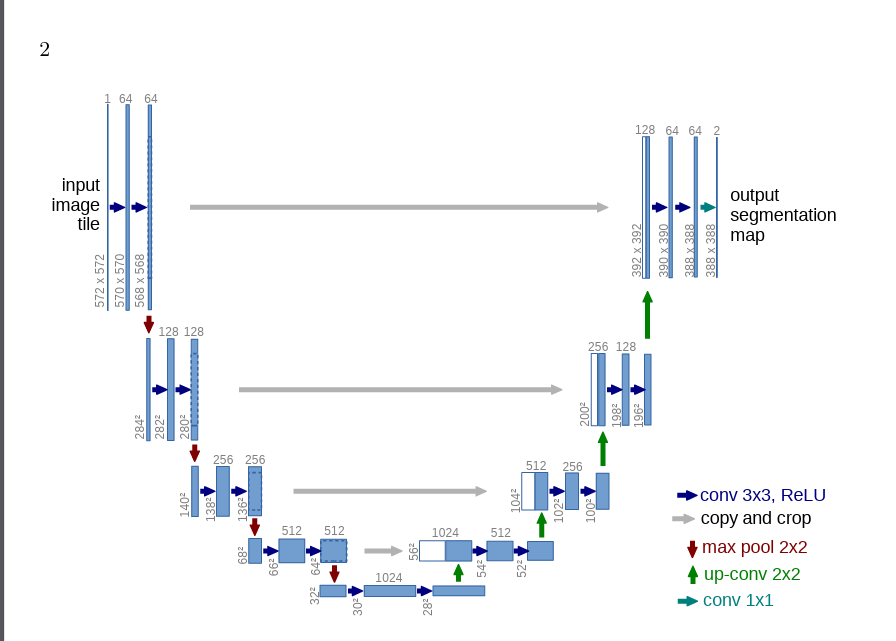

In [50]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2

In [58]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)

    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


In [59]:
class Encoder(nn.Module):
    def __init__(self, chs=(1,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)

    def forward(self, x):
        encoder_ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            encoder_ftrs.append(x)
            x = self.pool(x)
        return encoder_ftrs

In [60]:
encoder = Encoder()
y = encoder(torch.randn(1,1,572,572))
for i in y:
  print(i.shape)

torch.Size([1, 64, 568, 568])
torch.Size([1, 128, 280, 280])
torch.Size([1, 256, 136, 136])
torch.Size([1, 512, 64, 64])
torch.Size([1, 1024, 28, 28])


In [61]:
class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])

    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = v2.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


In [70]:
class UNet(nn.Module):
    def __init__(self, enc_chs=(1,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=2, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1) # output block
        self.retain_dim  = retain_dim
        self.out_sz = out_sz
        self.dec_chs = dec_chs

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        x      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        x      = self.head(x)

        if self.retain_dim:
            x = F.interpolate(x, self.out_sz)
        return x

In [71]:
device = "cuda" if torch.cuda.is_available() else "cpu"
def test():
  x = torch.randn((1,1,572,572))
  unet = UNet()
  y = unet(x).to(device)
  print(y.shape)
  return y

test()

# nice! works good.

torch.Size([1, 2, 388, 388])


tensor([[[[0.1185, 0.1221, 0.1037,  ..., 0.1453, 0.1324, 0.1648],
          [0.1233, 0.1126, 0.1103,  ..., 0.1208, 0.1409, 0.1587],
          [0.1214, 0.1028, 0.1219,  ..., 0.1013, 0.1268, 0.1299],
          ...,
          [0.1024, 0.1200, 0.1477,  ..., 0.1080, 0.1503, 0.1457],
          [0.1202, 0.1244, 0.1539,  ..., 0.1167, 0.1352, 0.0953],
          [0.1027, 0.1163, 0.1189,  ..., 0.1374, 0.1486, 0.1419]],

         [[0.0748, 0.1326, 0.0768,  ..., 0.1243, 0.1086, 0.0762],
          [0.0989, 0.0993, 0.0903,  ..., 0.1428, 0.0943, 0.0931],
          [0.1668, 0.1122, 0.0907,  ..., 0.1454, 0.0823, 0.1306],
          ...,
          [0.1078, 0.0896, 0.1040,  ..., 0.0974, 0.1020, 0.1220],
          [0.1109, 0.1060, 0.0724,  ..., 0.0976, 0.1141, 0.1312],
          [0.1201, 0.0795, 0.1041,  ..., 0.0782, 0.1263, 0.1219]]]],
       grad_fn=<ConvolutionBackward0>)